In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import random
import shapely

from shapely import Polygon, Point, affinity
from shapely.geometry import box
from shapely.ops import snap
from itertools import combinations
from sklearn.cluster import KMeans

In [52]:
def move_gdf(gdf_poly, gdf_dest):
    gdf_new = gdf_poly.copy()
    gdf_new['delta_x'] = gdf_dest['geometry'].x - gdf_new['geometry'].centroid.x
    gdf_new['delta_y'] = gdf_dest['geometry'].y - gdf_new['geometry'].centroid.y
    gdf_new['geometry'] = gdf_new.apply(lambda gdf: affinity.translate(gdf.loc['geometry'], xoff=gdf.loc['delta_x'], yoff=gdf.loc['delta_y']), axis=1)
    # adding in a random rotation element
    gdf_new['geometry'] = gdf_new.apply(lambda gdf: affinity.rotate(gdf.loc['geometry'], 90 * random.choice([0,1,2,3]), 'center'), axis=1)
    return gdf_new[gdf_new['geometry'].geom_type != 'Point']


def find_overlaps(gdf):
    """Returns a list of tuples identifying the geometries
    that overlap one another.
    """
    overlaps, retouch = [], {}
    for x, y in combinations(gdf.index.tolist(), 2):
        g_x = gdf.loc[x].geometry
        g_y = gdf.loc[y].geometry
        if g_x.intersects(g_y):
            overlaps.append([x, y])

    for t, b in overlaps:
        retouch.setdefault(t, []).append(b)

    return overlaps, retouch


def clip_overlaps_by_weight(gdf, col, tol=0.0000001):
    """Clips out overlapping geometries within a shapefile
    ranked by an attribute.
    """

    gdf.sort_values(by=col, axis=0, ascending=False, inplace=True)
    gdf.reset_index(drop=True, inplace=True)
    dupd = gdf.geometry.duplicated()
    if dupd.any():  # keep highest weighted duplicate, remove the rest
        gdf = gdf.loc[~dupd]

    overlaps, retouch = find_overlaps(gdf)

    for overlap in overlaps:
        top, bot = gdf.loc[overlap].geometry
        try:
            bot = bot.difference(top)
        except:
            breakpoint()
        top = snap(top, bot, tol)
        gdf.loc[overlap, "geometry"] = gpd.GeoSeries([top, bot], index=overlap)

    for clipper, clip_list in retouch.items():
        for clipped in clip_list[:-1]:
            top, bot = gdf.loc[[clipper, clipped]].geometry
            gdf.loc[clipped, "geometry"] = snap(bot, top, tol)

    return gdf#.sort_values(by="index").drop("index", axis=1)

def multi_to_poly(gdf):
    polys = []
    for geom in gdf.geometry:
        if isinstance(geom, shapely.geometry.multipolygon.MultiPolygon):
            for y in geom.geoms:
                polys.append(y)
        else:
            polys.append(geom)
    return gpd.GeoDataFrame(geometry=polys, crs=3857)#.reset_index(drop=True)

def poly_bb_ratio(poly):
    min_x, min_y, max_x, max_y = poly.bounds
    bb = gpd.GeoSeries(box(min_x, min_y, max_x, max_y, ccw=True))
    ratio = float(1/(poly.area/bb.area))
    if ratio < 1.8:
        return 1.8
    return ratio

def points_uniform(poly, num_points):
    min_x, min_y, max_x, max_y = poly.bounds
    poly_ratio = poly_bb_ratio(poly)
    poly_gdf = gpd.GeoDataFrame(pd.DataFrame([poly], columns=['geometry']), geometry='geometry', crs=3857)

    points = []
    # Generates points repeatedly with a uniform generation within the bounds of the polygon
    while len(points) < round(num_points * poly_ratio):
        points.append(Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)]))
    gdf = gpd.GeoDataFrame(pd.DataFrame(points, columns=['geometry']), geometry='geometry', crs=3857)
    gdf = gdf.sjoin(poly_gdf, predicate='within')
    gdf = gdf.drop(['index_right'], axis=1)

    return gdf.iloc[0:num_points].reset_index(drop=True)

def kmeans_polys(num_cluster, polys):
    # The geometries of the Shapely points are converted to a numpy array for use in the kmeans algorithm
    feature_coords = np.array([[e.x, e.y] for e in polys.centroid.geometry])

    # A kmeans object is created using the specified number of clusters
    kmeans = KMeans(num_cluster)
    kmeans.fit(feature_coords)

    # The cluster centres are stored as centroids, and this list is put into a GeoDataFrame and returned

    gdf = gpd.GeoDataFrame(pd.DataFrame(kmeans.labels_, columns=['cluster']), geometry=polys.geometry)

    return gdf

def shuffled_polys(poly_input, num_polys, crs=3857):
    poly_bounds = gpd.GeoDataFrame(geometry=gpd.GeoSeries(poly_input.unary_union, crs=crs))
    new_centroids = gpd.GeoDataFrame(pd.DataFrame(poly_input['geometry'].centroid.reset_index(drop=True), columns=['geometry']).sample(len(poly_input)).reset_index(drop=True), geometry='geometry')
    poly_moved = move_gdf(poly_input, new_centroids)

    #overlay1 = gpd.GeoDataFrame(geometry=poly_bounds).overlay(poly_moved, how='union')
    #overlay = gpd.GeoDataFrame(geometry=poly_bounds).overlay(overlay1, how='intersection')

    overlay = poly_bounds.overlay(poly_bounds.overlay(poly_moved, how='union'), how='intersection')#.reset_index(names='index')

    test = clip_overlaps_by_weight(overlay, 'id')
    test_polys = multi_to_poly(test)
    test_polys = test_polys[~test_polys.geometry.is_empty]  

    kmeans_out = kmeans_polys(num_polys, test_polys).sort_values('cluster').reset_index(drop=True)
    return kmeans_out.dissolve(by='cluster', as_index=False)

/home/paddy/miniconda3/envs/radian/lib/python3.11/site-packages/geopandas/geodataframe.py:1815: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union
/home/paddy/miniconda3/envs/radian/lib/python3.11/site-packages/geopandas/geodataframe.py:2469: UserWarning: `keep_geom_type=True` in overlay resulted in 45 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(
/home/paddy/miniconda3/envs/radian/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<Axes: >

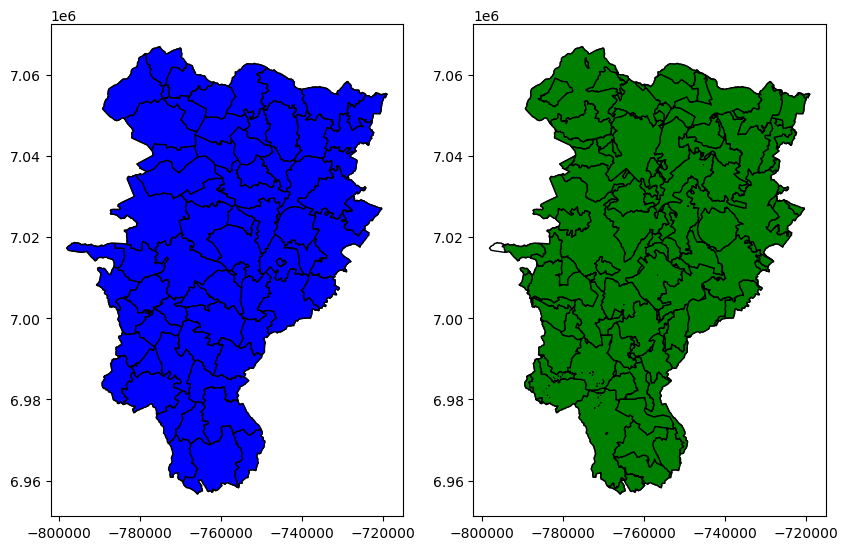

In [48]:
kildare = gpd.read_file("kildare.json").to_crs(3857)
kildare_bounds = gpd.GeoSeries(kildare.unary_union, crs=3857)
kildare_shuffle = shuffled_polys(kildare, len(kildare))

fig, ax = plt.subplots(1,2, figsize=(10,8))

for x in ax:
    kildare_bounds.plot(ax=x, edgecolor='black', facecolor='none')

kildare.plot(ax=ax[0], edgecolor='black', facecolor='blue')
kildare_shuffle.plot(ax=ax[1], edgecolor='black', facecolor='green')

/home/paddy/miniconda3/envs/radian/lib/python3.11/site-packages/geopandas/geodataframe.py:1815: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union
/home/paddy/miniconda3/envs/radian/lib/python3.11/site-packages/geopandas/geodataframe.py:2469: UserWarning: `keep_geom_type=True` in overlay resulted in 26 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


length: 49
length: 49


/home/paddy/miniconda3/envs/radian/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/paddy/miniconda3/envs/radian/lib/python3.11/site-packages/geopandas/geodataframe.py:1815: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union


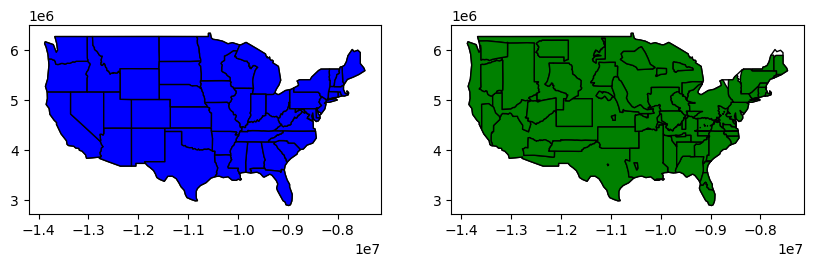

In [68]:
usa = gpd.read_file("contiguous-usa.geojson").to_crs(3857)
usa = usa.sample(len(usa)).reset_index(names='id')

usa_bounds = gpd.GeoSeries(usa.unary_union, crs=3857)
usa_shuffle = shuffled_polys(usa, len(usa))

fig, ax = plt.subplots(1,2, figsize=(10,8))

for x in ax:
    usa_bounds.plot(ax=x, edgecolor='black', facecolor='none')

usa.plot(ax=ax[0], edgecolor='black', facecolor='blue')
usa_shuffle.plot(ax=ax[1], edgecolor='black', facecolor='green')

print("length:", len(usa))
print("length:", len(usa_shuffle))